In [38]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# load modules related to this exercise
import NPL
from model_zucher import zurcher
from Solve_NFXP import solve_NFXP
from estimate_NFXP import estimate as NFXP_estimate



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Problem set 5

#### 1. Look at the ReadMe.txt to get an overview of the code

#### 2.What is the difference between $EV(x,a)$ and $V_{\sigma}(x)$? 

#### 3. Write the formula for $P=\Lambda(V_{\sigma})$, $V_{\sigma}=\psi(P)$ and $P=\Psi(P)$, exploiting the extreme value type I distribution on $\epsilon$. 
Hint: what is $e(a,P)\equiv E[\epsilon(a)|x,a]$ under this distributional assumption? 

Insert the found formulars under zucher.psi ($V_{\sigma}=\psi(P)$) and zucher.lambdaa ( $P=\Lambda(V_{\sigma})$)

#### 4. Solve the model using NPL, and plot the convergence of psi to check that your results are correct

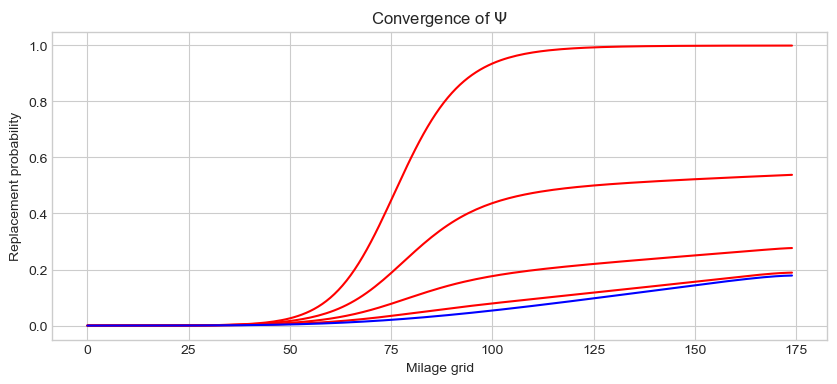

In [39]:
# SETUP
model = zurcher()

# SOLVE THE MODEL
pk_NPL = NPL.solve(model)

fig = plt.figure(figsize=(10,4)) 
ax = fig.add_subplot(1,1,1)

ax.set_title(f'Convergence of $\Psi$')
ax.set_xlabel('Milage grid')
ax.set_ylabel('Replacement probability')
for i in range(4):
    ax.plot(model.grid,1-pk_NPL[i+1,:],color = 'red')
ax.plot(model.grid,1-pk_NPL[99,:],color = 'blue')
plt.show()

#### 5. Now you have to compare NFXP and NPL. Remeber that NFXP solve the fixed-point problem in value function space ( EV = Γ( EV ) ) and NPL solves it in CCP space ( pk = Ψ( pk ) ). Calculate the CCPs from either method and compare the results

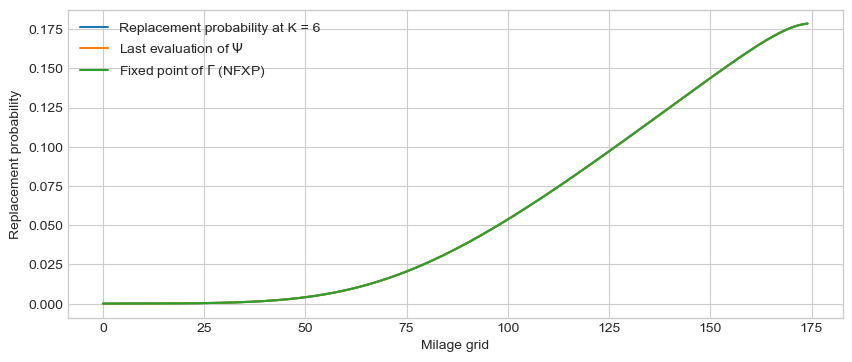

In [40]:
# solve the model with NFXP
ev0 = np.zeros(model.n)
solver_NFXP = solve_NFXP()
_, pk_NFXP = solver_NFXP.poly(model.bellman, ev0, beta=model.beta, output=2)


# Define figure
fig = plt.figure(figsize=(10,4)) 
ax = fig.add_subplot(1,1,1)



ax.plot(model.grid,1-pk_NPL[6,:],label=f'Replacement probability at K = 6')
ax.plot(model.grid,1-pk_NPL[99,:],label=f'Last evaluation of $\Psi$')
ax.plot(model.grid,1-pk_NFXP,label=f'Fixed point of $\Gamma$ (NFXP)')

ax.set_xlabel('Milage grid')
ax.set_ylabel('Replacement probability')
plt.legend()

plt.show()

#### 6. $F^{U}(pk)$ is the unconditional transition probabilities induced by pk (vector) - what does that mean? 
(a) Try changing the number of gridpoints to 5 and the transition probability vector to a scalar of 0.65, place a debugger (alternatively print statement) in the model_zucher_exante.psi.py-function and compare Fu and P1. What is the difference between the two? 

In [41]:
do_settings = {
    'n': 5,
    'p':[0.65]   
}
model = zurcher(**do_settings)

# SOLVE THE MODEL
pk_NPL = NPL.solve(model)

#### 7. What determines if NFXP is computationally cheaper to use than NPL? Think about what is in the inner loop of either algorithm. 

#### 8. Now we have to Estimate the model using NPL. In order to estimate the model you should understand 
<il type ="a">
<li> NPL.estimate </li>
<li> NPL.ll (skip the part of computing the gradient and the Hessian)</li>
</il>

#### 9. Fill in the missing stuff in NPL.ll, and run the code below to check that your results are correct

In [42]:
 # ESTIMATE
# setup
Kmax=10  # Max number of outer loop iterations for NPL 
pnames = ['RC','c']
model = zurcher()

# Load data
data = model.read_busdata(bustypes=[1,2,3,4])
data_class = NPL.setup_data(data)
samplesize = data_class.x.size

#Estimate using NPL
import time
t0 = time.time()
res, theta_hat,pk = NPL.estimate(model, data_class, Kmax)
t1 = time.time()

# Print the results
print(f'Structual estimation using busdata from Rust(1987)')
print(f'Beta        = {model.beta:.4f}')
print(f'n           = {model.n}')
print(f'Sample size = {samplesize}')

print('\n \nNPL \n--------------------------------')
print(f'Parameters     Estimates    s.e. ') 
print(f'{pnames[0]}             {theta_hat[0]:.4f}     ')
print(f'{pnames[1]}              {theta_hat[1]:.4f}      \n ')


print(f'Log-likelihood {-res.fun*samplesize:.4f}') 
print(f'runtime (seconds) {(t1-t0):.4f}')

# Estimate using NFXP
theta0 = (0.,0.)
solver_NFXP = solve_NFXP()
t0 = time.time()
nfxp_model, optim_res, pnames, theta_hat, Avar, converged=NFXP_estimate(model, solver_NFXP,data,theta0=theta0, twostep=0)

t1 = time.time()
time = t1-t0

# Print the result
print('\n \nNFXP \n--------------------------------')
print(f'Parameters     Estimates    s.e. ') 
print(f'{pnames[0]}             {theta_hat[0]:.4f}     {np.sqrt(Avar[0,0]):.4f} ')
print(f'{pnames[1]}              {theta_hat[1]:.4f}     {np.sqrt(Avar[1,1]):.4f} \n ')

print(f'Log-likelihood {-optim_res.fun*samplesize:.2f}') 
print(f'runtime (seconds) {time:.4f}')

Structual estimation using busdata from Rust(1987)
Beta        = 0.9999
n           = 175
Sample size = 8156

 
NPL 
--------------------------------
Parameters     Estimates    s.e. 
RC             9.7711     
c              1.3433      
 
Log-likelihood -300.5699
runtime (seconds) 0.6555

 
NFXP 
--------------------------------
Parameters     Estimates    s.e. 
RC             9.7689     1.2264 
c              1.3427     0.3153 
 
Log-likelihood -8599.86
runtime (seconds) 5.1223
